In [5]:
import requests
import os
from tqdm import tqdm
from Pix2Code.data_utils.screenshot import take_screenshot
from gpt4v_utils import cleanup_response, encode_image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def gpt4v_call(api_key, image_path, prompt):
	# Getting the base64 string
	base64_image = encode_image(image_path)

	headers = {
		"Content-Type": "application/json",
		"Authorization": f"Bearer {api_key}"
	}

	payload = {
		"model": "gpt-4-vision-preview",
		"messages": [
		{
			"role": "user",
			"content": [
			{
				"type": "text",
				"text": prompt
			},
			{
				"type": "image_url",
				"image_url": {
				"url": f"data:image/jpeg;base64,{base64_image}",
				"detail": "high"
				}
			}
			]
		}
		],
		"max_tokens": 3200
	}

	response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
	response = response.json()
	response = response["choices"][0]["message"]["content"].strip()
	
	response = cleanup_response(response)

	return response

In [3]:
with open("../../api_key.txt") as f:
	api_key = f.read().strip()

In [4]:
with open("gpt_4v_prompt.txt") as f:
	direct_prompt = f.read().strip()

In [8]:
test_data_dir = "../../testset_100"
predictions_dir = "./prototyping/"
        

In [13]:
from playwright.async_api import async_playwright
import os
import asyncio

async def take_screenshot(url, output_file="screenshot.png"):
    if os.path.exists(url):
        url = "file://" + os.path.abspath(url)

    async with async_playwright() as p:
        browser = await p.chromium.launch()
        page = await browser.new_page()
        await page.goto(url)
        await page.screenshot(path=output_file, full_page=True)
        await browser.close()

In [14]:
filename = "6.png"

# Get or create an event loop
loop = asyncio.get_event_loop()

# Check if the loop is already running
if not loop.is_running():
    loop.run_until_complete(take_screenshot(os.path.join(predictions_dir, filename.replace(".png", ".html")), os.path.join(predictions_dir, filename)))
else:
    # Schedule the coroutine to run and return a future
    task = loop.create_task(take_screenshot(os.path.join(predictions_dir, filename.replace(".png", ".html")), os.path.join(predictions_dir, filename)))

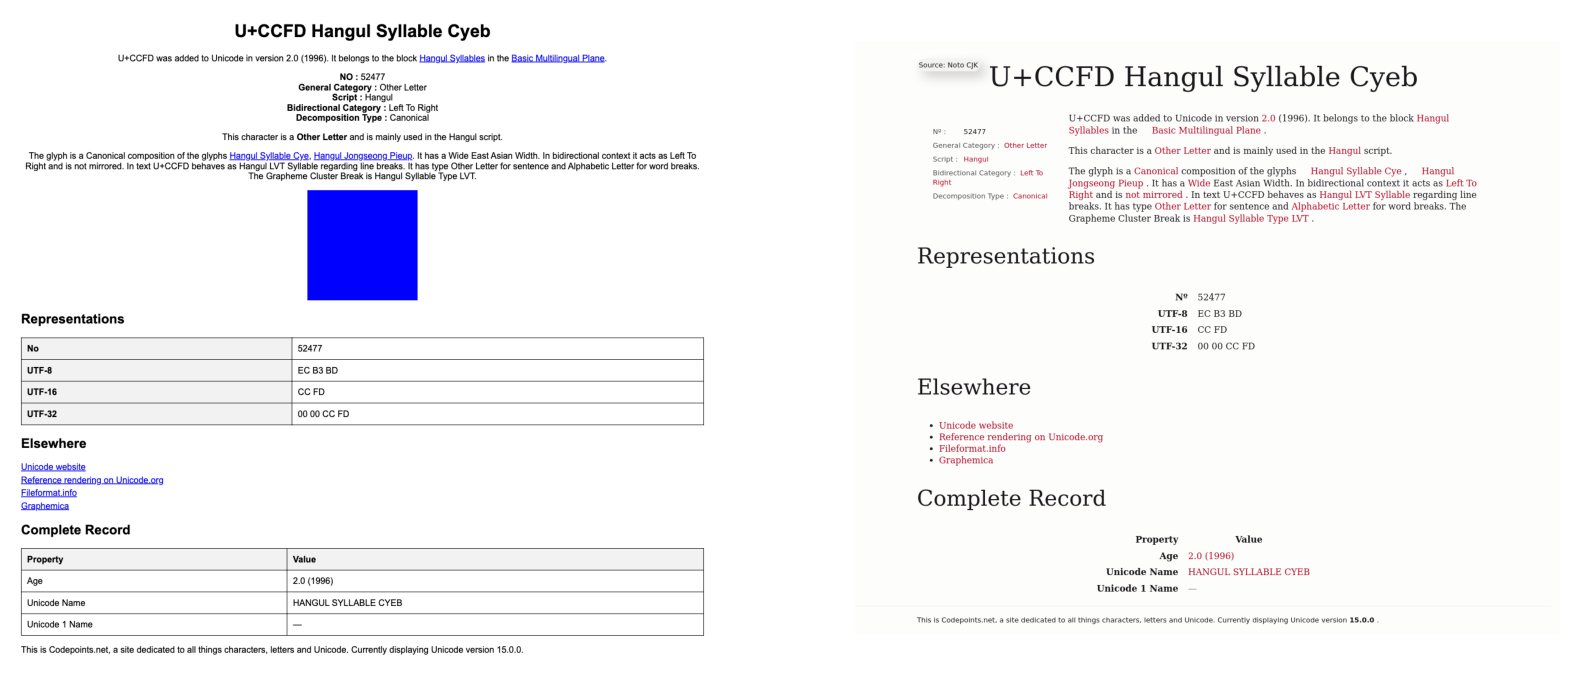

In [15]:
img1 = cv2.imread(os.path.join(predictions_dir, filename))
img2 = cv2.imread(os.path.join(test_data_dir, filename))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [16]:
layout_prompt = '''
You are an expert web developer who specializes in HTML and CSS.
A user will provide you with a screenshot of a webpage. 
You need to return a single html file that uses HTML and CSS to reproduce the given website.
Include any extra CSS in the HTML file itself.
If it involves any images, use \"rick.jpg\" as the placeholder.
Some images on the webpage are replaced with a blue rectangle as the placeholder, use \"rick.jpg\" for those as well.
Do not hallucinate any dependencies to external files. You do not need to include any JavaScript scrips for dynamic interactions.
Focus on the layout structure of the website and do not worry about the content (you can leave blank or use placeholder text for now).
Respond ONLY with HTML and CSS code. 
'''

In [17]:
html = gpt4v_call(api_key, os.path.join(test_data_dir, filename), layout_prompt)

In [18]:
with open(os.path.join(predictions_dir, filename.replace(".png", "_layout.html")), "w") as f:
    f.write(html)

In [30]:
def take_screenshot_and_show(filename, layout_prompt=True):
    # Get or create an event loop
    loop = asyncio.get_event_loop()

    # Check if the loop is already running
    if not loop.is_running():
        if layout_prompt:
            loop.run_until_complete(take_screenshot(os.path.join(predictions_dir, filename.replace(".png", "_layout.html")), os.path.join(predictions_dir, filename.replace(".png", "_layout.png"))))
        else:
            loop.run_until_complete(take_screenshot(os.path.join(predictions_dir, filename.replace(".png", ".html")), os.path.join(predictions_dir, filename)))
    else:
        # Schedule the coroutine to run and return a future
        if layout_prompt:
            task = loop.create_task(take_screenshot(os.path.join(predictions_dir, filename.replace(".png", "_layout.html")), os.path.join(predictions_dir, filename.replace(".png", "_layout.png"))))
        else:
            task = loop.create_task(take_screenshot(os.path.join(predictions_dir, filename.replace(".png", ".html")), os.path.join(predictions_dir, filename)))

    if layout_prompt:
        img1 = cv2.imread(os.path.join(predictions_dir, filename.replace(".png", "_layout.png")))
    else:
        img1 = cv2.imread(os.path.join(predictions_dir, filename))
    img2 = cv2.imread(os.path.join(test_data_dir, filename))

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

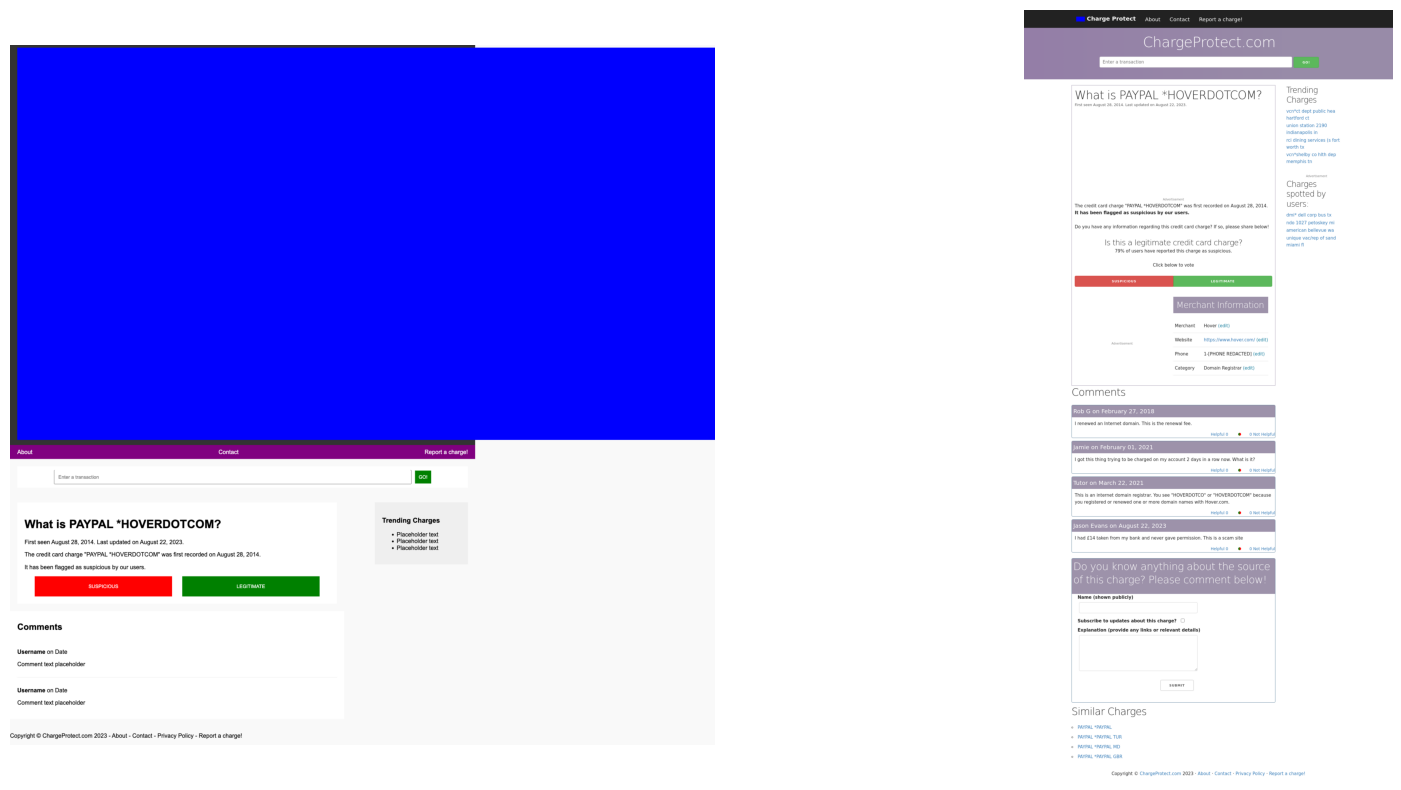

In [31]:
filename = "112.png"
html = gpt4v_call(api_key, os.path.join(test_data_dir, filename), direct_prompt)
with open(os.path.join(predictions_dir, filename.replace(".png", ".html")), "w") as f:
    f.write(html)
take_screenshot_and_show(filename, layout_prompt=False)

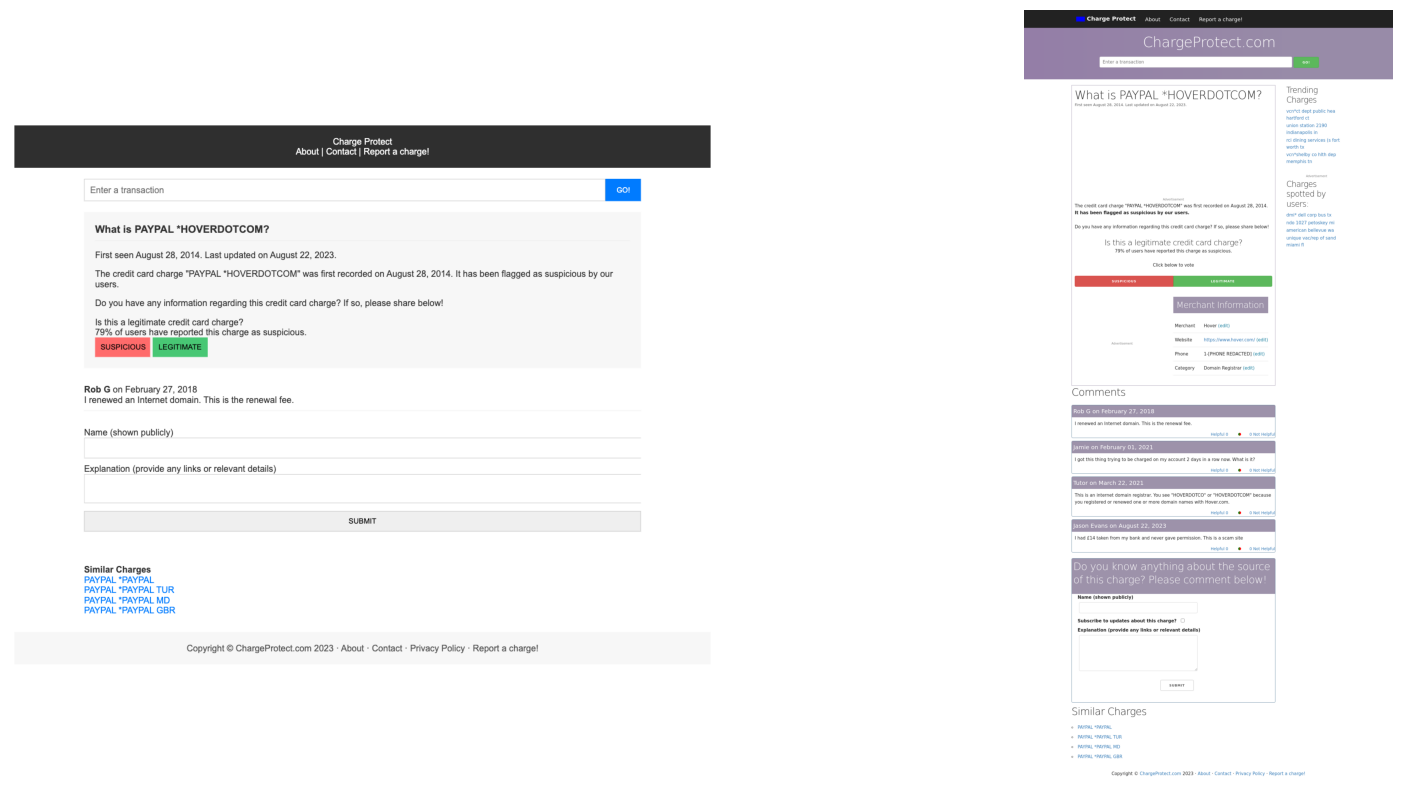

In [33]:
filename = "112.png"
html = gpt4v_call(api_key, os.path.join(test_data_dir, filename), layout_prompt)
with open(os.path.join(predictions_dir, filename.replace(".png", "_layout.html")), "w") as f:
    f.write(html)
take_screenshot_and_show(filename, layout_prompt=True)

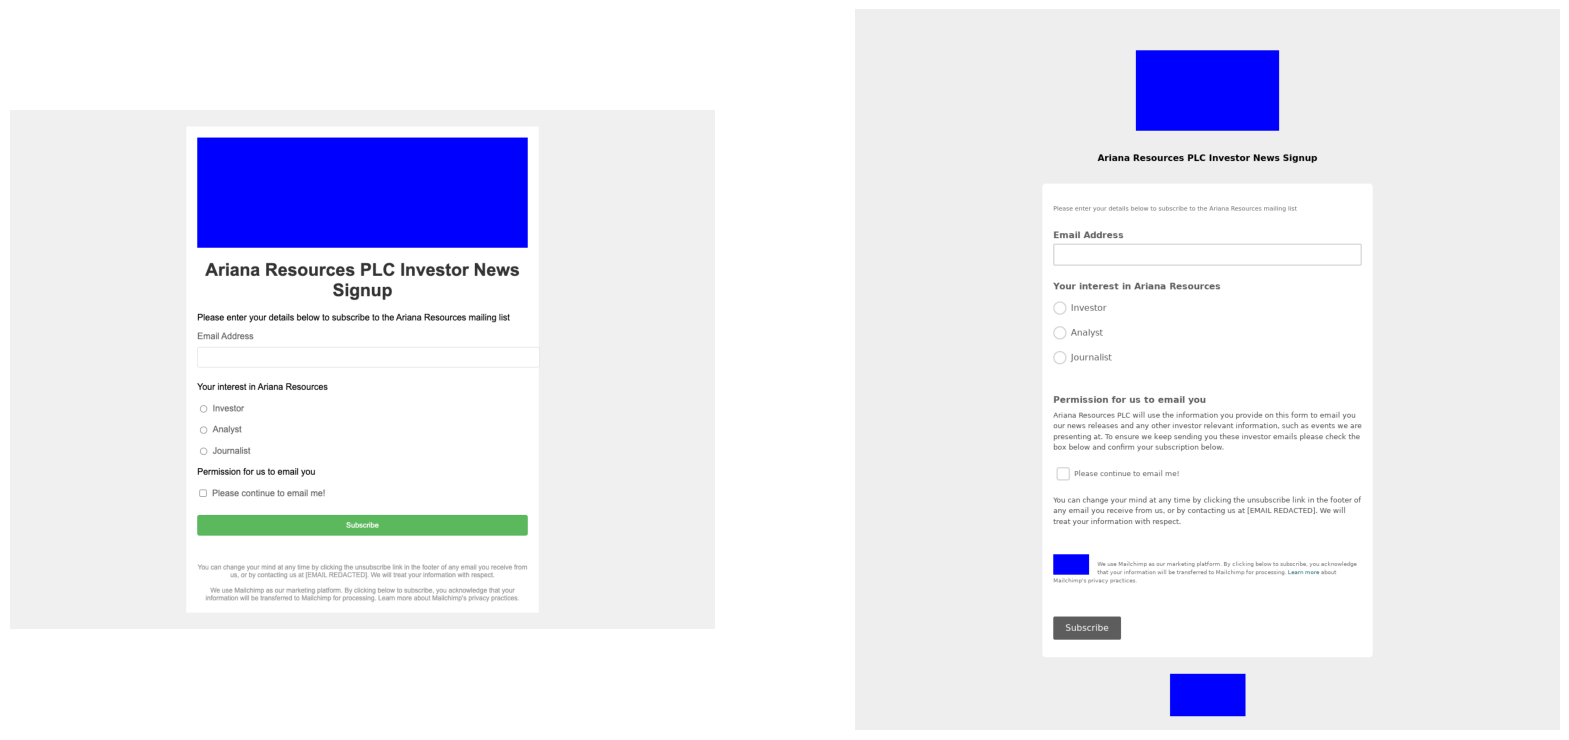

In [35]:
filename = "540.png"
html = gpt4v_call(api_key, os.path.join(test_data_dir, filename), direct_prompt)
with open(os.path.join(predictions_dir, filename.replace(".png", ".html")), "w") as f:
    f.write(html)
take_screenshot_and_show(filename, layout_prompt=False)

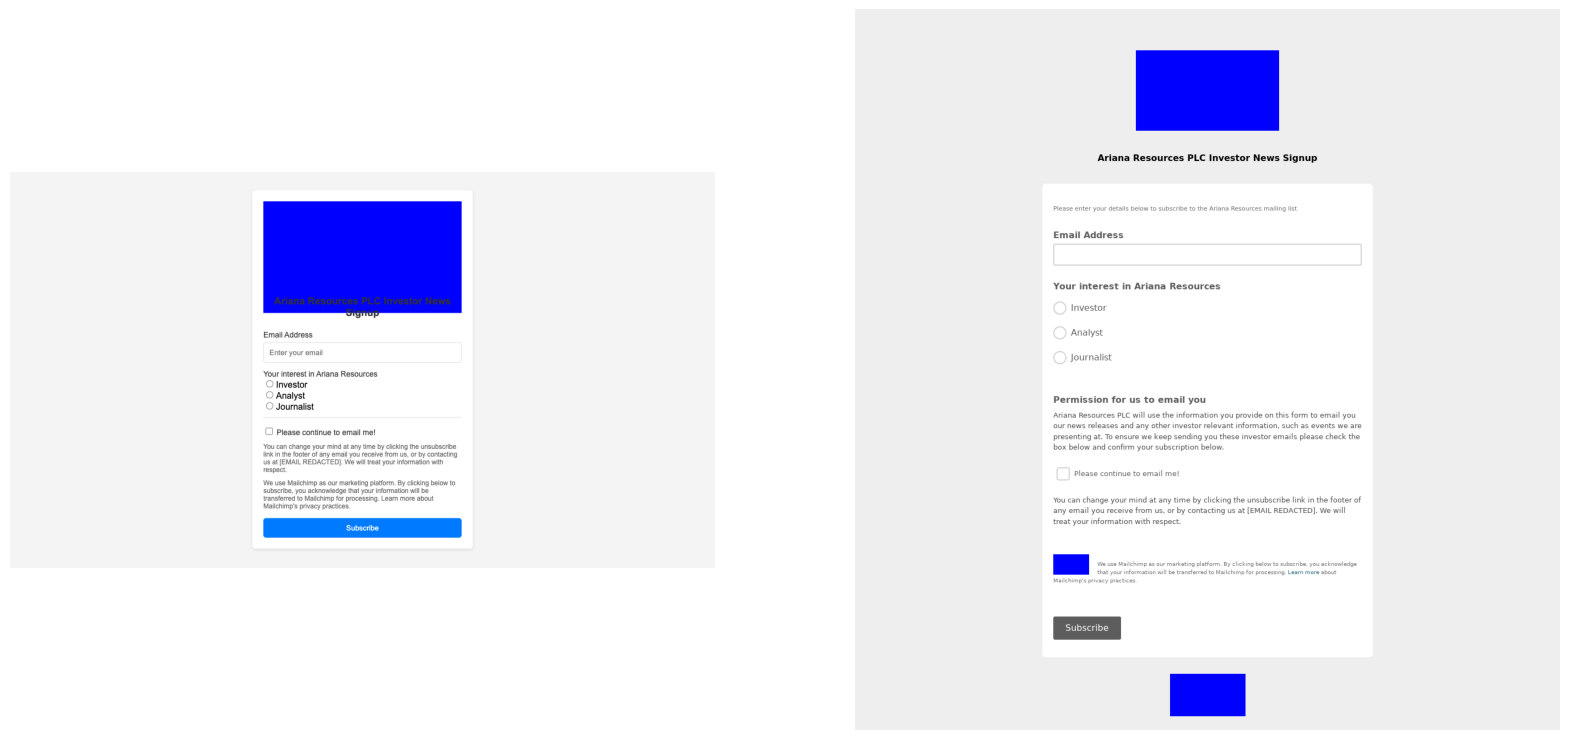

In [38]:
filename = "540.png"
html = gpt4v_call(api_key, os.path.join(test_data_dir, filename), layout_prompt)
with open(os.path.join(predictions_dir, filename.replace(".png", "_layout.html")), "w") as f:
    f.write(html)
take_screenshot_and_show(filename, layout_prompt=True)

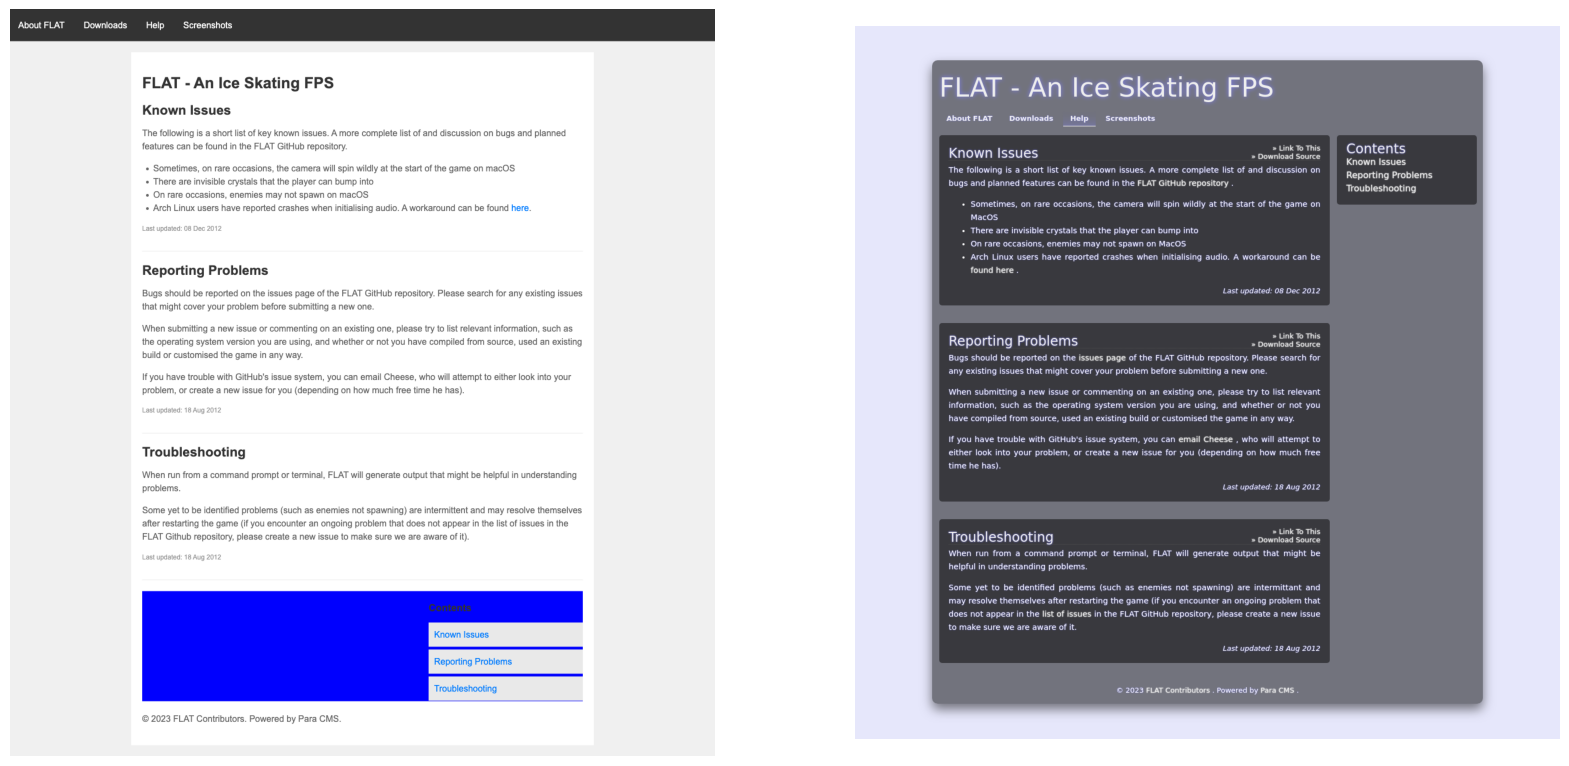

In [42]:
filename = "2064.png"
html = gpt4v_call(api_key, os.path.join(test_data_dir, filename), direct_prompt)
with open(os.path.join(predictions_dir, filename.replace(".png", ".html")), "w") as f:
    f.write(html)
take_screenshot_and_show(filename, layout_prompt=False)

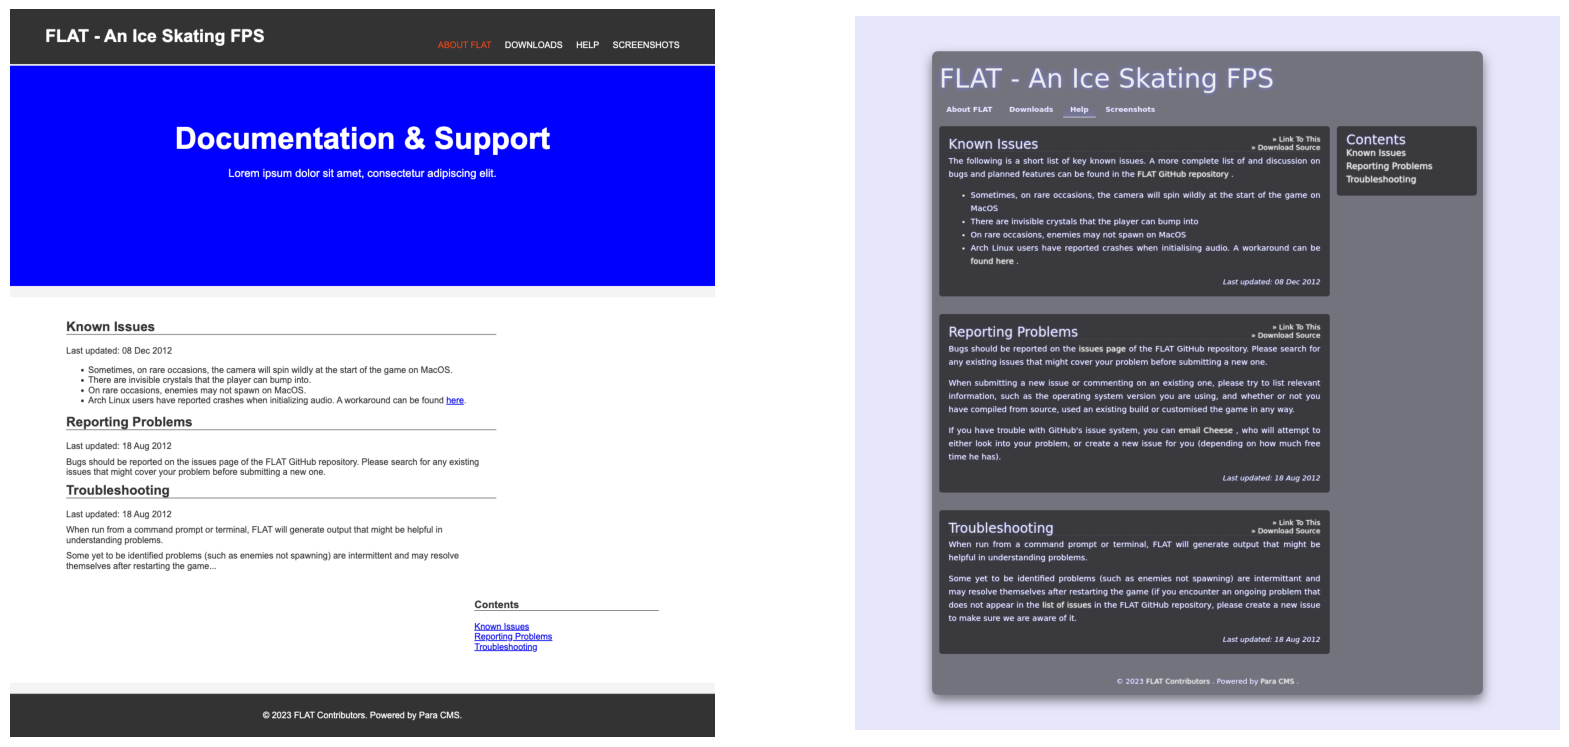

In [45]:
filename = "2064.png"
html = gpt4v_call(api_key, os.path.join(test_data_dir, filename), direct_prompt)
with open(os.path.join(predictions_dir, filename.replace(".png", "_layout.html")), "w") as f:
    f.write(html)
take_screenshot_and_show(filename, layout_prompt=True)

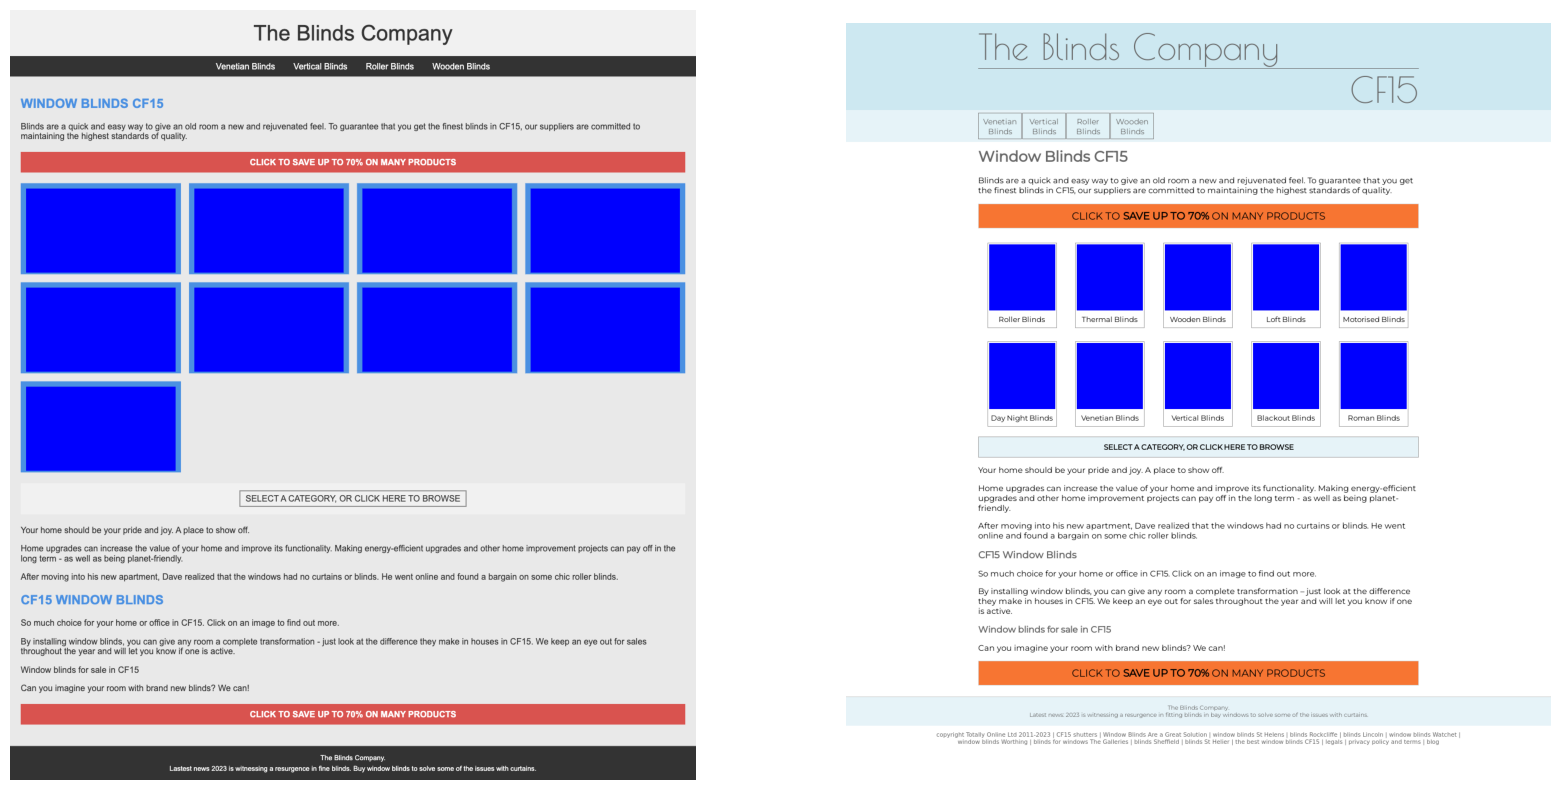

In [47]:
filename = "4097.png"
html = gpt4v_call(api_key, os.path.join(test_data_dir, filename), direct_prompt)
with open(os.path.join(predictions_dir, filename.replace(".png", ".html")), "w") as f:
    f.write(html)
take_screenshot_and_show(filename, layout_prompt=False)

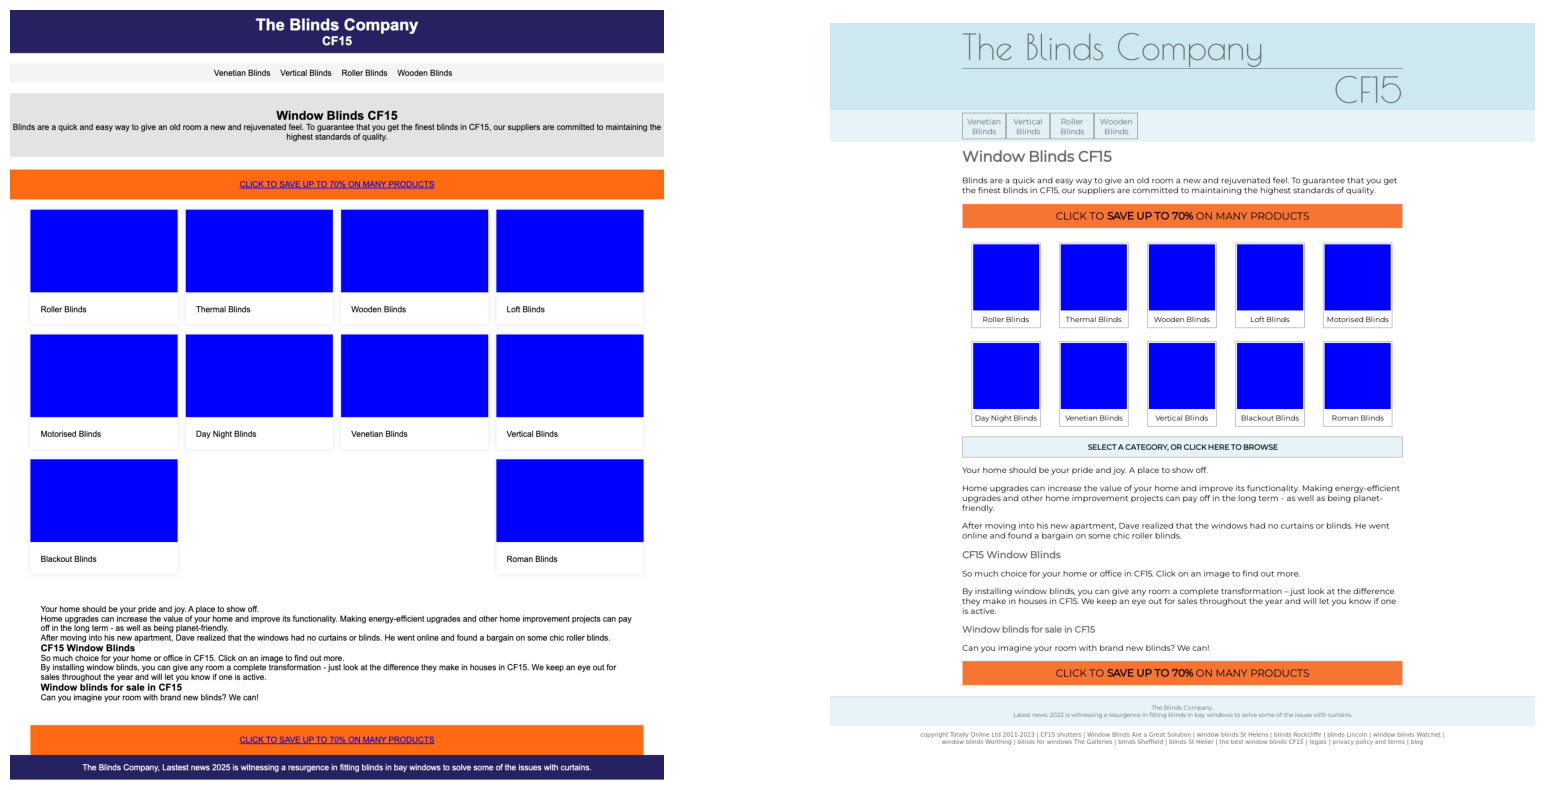

In [49]:
filename = "4097.png"
html = gpt4v_call(api_key, os.path.join(test_data_dir, filename), direct_prompt)
with open(os.path.join(predictions_dir, filename.replace(".png", "_layout.html")), "w") as f:
    f.write(html)
take_screenshot_and_show(filename, layout_prompt=True)